In [35]:
import os
import pandas as pd
import numpy as np
import ast
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis 
print(os.path.abspath(os.getcwd()))
curr_wd = os.path.abspath(os.getcwd())


/mnt/d/phd/scripts/11_repo_hu-RG-motif-composition_analysis


In [37]:
### LOAD AND CLEAN GAR MOTIF DATASET FOR HUMAN PROTEOME

# Load motif dataset from Wang et al. (GAR motif finder)
with open(curr_wd + '/data/external/GAR_motif_finder/UP000005640_9606.f.csv', "r") as f:
    tempset3 = pd.read_csv(f)

# Fill down missing accession numbers
for i, e in tempset3.iterrows():
    if pd.isnull(e['Accession number']):
        tempset3.at[i, 'Accession number'] = tempset3.at[i - 1, 'Accession number']

# Extract start and end positions from Position column
tempset3[['start', 'end']] = tempset3['Position'].str.split(r'\.\.', n=1, expand=True)
tempset3['start'] = pd.to_numeric(tempset3['start'])
tempset3['end'] = pd.to_numeric(tempset3['end'])

# Split Accession number into database, unique UniProt ID, and entry name
tempset3[['db', 'UniqueID', 'EntryName']] = tempset3['Accession number'].str.split('|', expand=True)
tempset3['EntryName'] = tempset3['EntryName'].str.split(" ").str[0]

# Calculate motif length
tempset3['length_motif'] = tempset3['end'] - tempset3['start'] + 1

# Parse stringified dictionaries in Else column
tempset3['Else'] = tempset3['Else'].apply(lambda x: ast.literal_eval(str(x)))

# Compute R-to-G ratio within GAR motif
tempset3['r_to_g_ratio'] = tempset3['Gs/Rs in GAR'] ** (-1)

# Rename columns for clarity
tempset3.rename(columns={
    "Pattern": "motif",
    "G%": "g_perc",
    "R%": "r_perc"
}, inplace=True)

# Retrieve full sequences from reference human proteome dataframe
tempset3['full_seq'] = [
    pseqs_df[pseqs_df['UniqueIdentifier'] == uid]['sequences'].tolist()[0]
    for uid in tempset3["UniqueID"].tolist()
]

# Select and reorder relevant columns
set3 = tempset3[[
    'UniqueID', 'EntryName', 'motif', 'r_to_g_ratio',
    'g_perc', 'r_perc', 'start', 'end', 'full_seq', 'Else'
]]

# Save cleaned dataset to CSV and Parquet formats
filepath = curr_wd + '/data/processed/'
set3.to_csv(filepath + 'GAR_motif_Wang_set_human_cleaned.csv', index=False)
set3.to_parquet(filepath + 'GAR_motif_Wang_set_human_cleaned.parquet', index=False)


In [39]:
########################################
# AGGREGATE ANNOTATIONS FOR THE ENTIRE HUMAN PROTEOME
# This pre-fetches all data (domains, IDRs, PTMs, GO, LLPS) to avoid repeated lookups later.
########################################

import os
import pandas as pd
import numpy as np
from ast import literal_eval
from feature_annotations import annot_domains, annot_PTMs, annot_IDR, annot_GO, annot_ELM

# Paths
annot_path = curr_wd + '/data/processed/annotation_datasets/'
os.makedirs(annot_path + "failed_requests", exist_ok=True)

# Load list of UniProt IDs
protein_list = pd.read_csv(
    curr_wd + '/data/processed/list_of_human_proteins.csv',
    header=None,
    names=["UniqueID"]
)['UniqueID'].tolist()

##### DOMAINS #####
failed_attempts, annotated_domains_df = annot_domains(
    protein_list, return_failed_attempts=True, show_progress=True
)
annotated_domains_df.to_csv(annot_path + "all_domains_human.csv", index=False)
annotated_domains_df.to_parquet(annot_path + "all_domains_human.parquet", index=False)
failed_attempts.to_csv(annot_path + "failed_requests/domains_human_failed_requests.csv", index=False)

# RUNTIME: ~1h

##### IDRs #####
failed_attempts, annotated_IDR_df = annot_IDR(
    protein_list, return_failed_attempts=True, show_progress=True
)
annotated_IDR_df.to_csv(annot_path + "all_IDR_human.csv", index=False)
annotated_IDR_df.to_parquet(annot_path + "all_IDR_human.parquet", index=False)
failed_attempts.to_csv(annot_path + "failed_requests/IDRs_human_failed_requests.csv", index=False)

# RUNTIME: ~75min

##### PTMs #####
failed_attempts, annotated_PTMs_df = annot_PTMs(
    protein_list, return_failed_attempts=True, show_progress=True, verbose=True
)
annotated_PTMs_df.to_csv(annot_path + "all_PTMs_human.csv", index=False)
annotated_PTMs_df.to_parquet(annot_path + "all_PTMs_human.parquet", index=False)
failed_attempts.to_csv(annot_path + "failed_requests/PTMs_human_failed_requests.csv", index=False)

# RUNTIME: ~86min

##### GO Terms #####
failed_attempts, annotated_GOs_df = annot_GO(
    protein_list, return_failed_attempts=True, show_progress=True, verbose=True
)
annotated_GOs_df.to_csv(annot_path + "all_GO_human.csv", index=False)
annotated_GOs_df.to_parquet(annot_path + "all_GO_human.parquet", index=False)
failed_attempts.to_csv(annot_path + "failed_requests/GO_human_failed_requests.csv", index=False)

# RUNTIME: ~39min

##### LLPS Predictions (PhaSePred) #####
df = pd.read_json(curr_wd + '/data/external/PhasePred/human_reviewed.json')
df = df.T.reset_index().rename(columns={"index": "UniqueID"})
llps_pred_df = df[['UniqueID', 'Sequence', 'PhaSePred']]
llps_pred_df.to_csv(annot_path + "phasepred_human.csv", index=False)

# RUNTIME: ~22 sec


0 / 20580 done!
Error accessing UniProt API for protein A0A075B6Y1: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein A0A3B3IRS2: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein Q5W150: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein Q5XG85: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein Q6ZS92: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein Q6ZSR6: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein Q8N814: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein Q8N976: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein Q8N9P0: Expecting value: line 1 column 1 (char 0)


KeyboardInterrupt: 

In [42]:
import pandas as pd
from ast import literal_eval
import numpy as np

# Load annotation datasets
annotated_domains_df = pd.read_csv(annot_path + "all_domains_human.csv")
annotated_IDR_df = pd.read_parquet(annot_path + "all_IDR_human.parquet")
annotated_PTMs_df = pd.read_csv(annot_path + "all_PTMs_human.csv")
annotated_GO_df = pd.read_parquet(annot_path + "all_GO_human.parquet")

llps_pred_df = pd.read_csv(annot_path + "phasepred_human.csv")
llps_pred_df["PhaSePred"] = llps_pred_df["PhaSePred"].apply(literal_eval)

dataset_base_name = "GAR_motif_Wang_set_human"
motif_info_set_df = pd.read_parquet(curr_wd + '/data/processed/' + dataset_base_name + "_cleaned.parquet")

##### GO TERMS #####
go_terms_all, go_aspects_all = [], []
invs_RNAbind_all, invs_DNAbind_all, invs_NAbind_all = [], [], []

for _, motif in motif_info_set_df.iterrows():
    curr_df = annotated_GO_df[annotated_GO_df['UniqueID'] == motif['UniqueID']]

    if curr_df.empty:
        go_terms_all.append([])
        go_aspects_all.append([])
        invs_RNAbind_all.append(0)
        invs_DNAbind_all.append(0)
        invs_NAbind_all.append(0)
        continue

    go_terms_all.append(curr_df["go_terms"].iloc[0])
    go_aspects_all.append(curr_df["go_aspects"].iloc[0])
    invs_RNAbind_all.append(curr_df["invs_RNAbind"].iloc[0])
    invs_DNAbind_all.append(curr_df["invs_DNAbind"].iloc[0])
    invs_NAbind_all.append(curr_df["invs_NAbind"].iloc[0])

motif_info_set_df['go_terms'] = go_terms_all
motif_info_set_df['go_aspects'] = go_aspects_all
motif_info_set_df['invs_RNAbind'] = invs_RNAbind_all
motif_info_set_df['invs_DNAbind'] = invs_DNAbind_all
motif_info_set_df['invs_NAbind'] = invs_NAbind_all

##### DOMAINS #####
part_of_domains, domain_names, domain_go, domain_distance = [], [], [], []

for _, motif in motif_info_set_df.iterrows():
    curr_df = annotated_domains_df[annotated_domains_df['protein_name'] == motif['UniqueID']]
    part_temp, names_temp, go_temp, dist_temp = [], [], [], []

    for _, domain in curr_df.iterrows():
        names_temp.append(domain["name"])
        go_temp.append(domain["GO_identifiers"])

        if ((domain["start"] >= motif["start"] and domain["end"] <= motif["end"]) or
            (motif["start"] >= domain["start"] and motif["end"] <= domain["end"])):
            part_temp.append(True)
            dist_temp.append(None)
        else:
            part_temp.append(False)
            if domain["start"] < motif["start"]:
                dist_temp.append(domain["end"] - motif["start"])
            else:
                dist_temp.append(domain["start"] - motif["end"])

    part_of_domains.append(part_temp)
    domain_names.append(names_temp)
    domain_go.append(go_temp)
    domain_distance.append(dist_temp)

motif_info_set_df['part_of_domains'] = part_of_domains
motif_info_set_df['domain_names'] = domain_names
motif_info_set_df['domain_go'] = domain_go
motif_info_set_df['domain_distance'] = domain_distance

##### IDRs #####
IDR_position_temp, IDR_overlap_temp = [], []

for _, motif in motif_info_set_df.iterrows():
    curr_df = annotated_IDR_df[annotated_IDR_df['protein_name'] == motif['UniqueID']]

    if curr_df.empty:
        print("weirder fall, wo der eintrag nicht existiert")
        print(motif["UniqueID"])
        IDR_overlap_temp.append(np.nan)
        IDR_position_temp.append(np.nan)
        continue

    seq = curr_df['prediction-disorder-mobidb_lite'].iloc[0]

    if len(seq) <= motif['end']:
        print("weirder fall, wo die list zu lang oder zu kurz ist???")
        print(motif["UniqueID"])
        IDR_overlap_temp.append(np.nan)
        IDR_position_temp.append(np.nan)
        continue

    tempslice = seq[motif['start']:motif['end']]
    motif_middle = motif["start"] + len(motif['motif']) // 2

    if sum(tempslice) == len(tempslice):
        IDR_overlap_temp.append("yes")
        count_right = next((j for j in range(1, len(seq) - motif_middle)
                            if seq[motif_middle + j] != 1), len(seq) - motif_middle) - 1
        count_left = next((k for k in range(1, motif_middle)
                           if seq[motif_middle - k] != 1), motif_middle) - 1
        IDR_position_temp.append((count_right - count_left) / (count_left + count_right))
    elif sum(tempslice) > 0:
        IDR_overlap_temp.append("partial")
        if tempslice[0] == 1:
            IDR_position_temp.append(-1)
        elif tempslice[-1] == 1:
            IDR_position_temp.append(1)
        else:
            IDR_position_temp.append(0)
    else:
        IDR_overlap_temp.append("no")
        IDR_position_temp.append(None)

print("IDRs done!")
motif_info_set_df['IDR_overlap'] = IDR_overlap_temp
motif_info_set_df['IDR_position'] = IDR_position_temp

##### PTMs #####
PTM_names, PTM_distance, PTM_players, PTM_type = [], [], [], []

for _, motif in motif_info_set_df.iterrows():
    curr_df = annotated_PTMs_df[annotated_PTMs_df['protein_name'] == motif['UniqueID']]
    names_temp, dist_temp, players_temp, type_temp = [], [], [], []

    for _, ptm in curr_df.iterrows():
        names_temp.append(ptm["ptm"])
        if ptm['pos'] < motif['start']:
            dist_temp.append(ptm["pos"] - motif['start'])
        elif ptm["pos"] < motif["end"]:
            dist_temp.append(0)
        else:
            dist_temp.append(ptm["pos"] - motif['end'])
        players_temp.append(ptm['by'])
        type_temp.append(ptm['type'])

    PTM_names.append(names_temp)
    PTM_distance.append(dist_temp)
    PTM_players.append(players_temp)
    PTM_type.append(type_temp)

motif_info_set_df['PTM_names'] = PTM_names
motif_info_set_df['PTM_distance'] = PTM_distance
motif_info_set_df['PTM_players'] = PTM_players
motif_info_set_df['PTM_type'] = PTM_type

##### LLPS #####
llps_pred_score, llps_pred_rank = [], []

for _, motif in motif_info_set_df.iterrows():
    curr_df = llps_pred_df[llps_pred_df['UniqueID'] == motif['UniqueID']]
    if not curr_df.empty:
        llps_pred_score.append(curr_df["PhaSePred"].iloc[0]['SaPS-8fea'])
        llps_pred_rank.append(curr_df["PhaSePred"].iloc[0]['PdPS-8fea'])
    else:
        llps_pred_score.append(np.nan)
        llps_pred_rank.append(np.nan)

motif_info_set_df['llps_pred_score'] = llps_pred_score
motif_info_set_df['llps_pred_rank'] = llps_pred_rank

# Save final annotated DataFrame
motif_info_set_df.to_parquet(curr_wd + '/data/processed/' + dataset_base_name + "_cleaned_annot.parquet", index=False)
motif_info_set_df.to_csv(curr_wd + '/data/processed/' + dataset_base_name + "_cleaned_annot.csv", index=False)


weirder fall, wo der eintrag nicht existiert
P0DV77
weirder fall, wo die list zu lang oder zu kurz ist???
Q8N436
weirder fall, wo die list zu lang oder zu kurz ist???
P16066
weirder fall, wo die list zu lang oder zu kurz ist???
D6REC4
weirder fall, wo der eintrag nicht existiert
A0A8V8TLL3
IDRs done!


In [57]:
motif_info_set_df

,UniqueID,EntryName,motif,r_to_g_ratio,g_perc,r_perc,start,end,full_seq,Else,...,domain_go,domain_distance,IDR_overlap,IDR_position,PTM_names,PTM_distance,PTM_players,PTM_type,llps_pred_score,llps_pred_rank
0,Q5SSQ6,SAPC1_HUMAN,QRGCTKGPRG,0.666667,30.000000,20.000000,135,144,MGSQGSGGVPLVQAPYTVLLLPLGTSRQDPGAQSFFLWLRRMQALE...,"{'A': None, 'C': 1.0, 'D': None, 'E': None, 'F...",...,[],[],yes,-0.500000,[],[],[],[],0.121801,0.086503
1,Q6ZWJ8,KCP_HUMAN,ERGSCCPRCRG,1.500000,18.181818,27.272727,950,960,MAGVGAAALSLLLHLGALALAAGAEGGAVPREPPGQQTTAHSSVLA...,"{'A': None, 'C': 3.0, 'D': None, 'E': 1.0, 'F'...",...,"[['GO:0005515'], [], []]","[-815.0, 242.0, 445.0]",no,NaN,"[N-linked (GlcNAc...) asparagine, N-linked (Gl...","[-610, -451, 130, 255, 277]","[[], [], [], [], []]","[CARBOHYD, CARBOHYD, CARBOHYD, DISULFID, DISUL...",0.064093,0.137329
2,Q7Z7L8,CK096_HUMAN,LRGRGFSRNPRGRGLPSGAGWRG,0.857143,30.434783,26.086957,146,168,MGNKQPQKVTVPTGTALQGVVLIVSTLHQPGGWICGKDPCCSLRPL...,"{'A': 1.0, 'C': None, 'D': None, 'E': None, 'F...",...,[],[],yes,0.551020,"[Phosphothreonine, Phosphoserine, Phosphoserin...","[200, 217, 231, 241, 257, 263]","[[], [], [], [], [], []]","[MOD_RES, MOD_RES, MOD_RES, MOD_RES, MOD_RES, ...",0.754444,0.483994
3,Q8IXZ2,ZC3H3_HUMAN,RRGACPRG,1.500000,25.000000,37.500000,783,790,MEEKEILRRQIRLLQGLIDDYKTLHGNAPAPGTPAASGWQPPTYHS...,"{'A': 1.0, 'C': 1.0, 'D': None, 'E': None, 'F'...",...,[['GO:0046872']],[-88.0],no,NaN,"[Phosphoserine, Phosphoserine, Phosphoserine]","[-375, 128, 130]","[[], [], []]","[MOD_RES, MOD_RES, MOD_RES]",0.599239,0.464699
4,Q8NAF0,ZN579_HUMAN,HRGRGRGRGRGRGRGRGRGRGG,0.909091,50.000000,45.454545,15,36,MDPQPPPPAQGSPPHRGRGRGRGRGRGRGRGRGRGGAGAPRAPLPC...,"{'A': None, 'C': None, 'D': None, 'E': None, '...",...,[[]],[8.0],yes,-0.219512,"[Omega-N-methylarginine, Phosphoserine, Phosph...","[56, 158, 160, 447]","[[], [], [], []]","[MOD_RES, MOD_RES, MOD_RES, MOD_RES]",0.389831,0.560056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,Q13470,TNK1_HUMAN,HRGTPARG,1.000000,25.000000,25.000000,455,462,MLPEAGSLWLLKLLRDIQLAQFYWPILEELNVTRPEHFDFVKPEDL...,"{'A': 1.0, 'C': None, 'D': None, 'E': None, 'F...",...,"[['GO:0004672', 'GO:0005524', 'GO:0006468'], [...","[-78.0, -81.0, -10.0, -78.0]",yes,0.404255,"[Phosphoserine, Phosphoserine, Phosphoserine, ...","[-395, -359, -200, 40, 52, 57, 120, -44]","[[], [], [], [], [], [], [], []]","[MOD_RES, MOD_RES, MOD_RES, MOD_RES, MOD_RES, ...",0.074419,0.463465
2115,Q6W4X9,MUC6_HUMAN,FRGQTRG,1.000000,28.571429,28.571429,525,531,MVQRWLLLSCCGALLSAGLANTSYTSPGLQRLKDSPQTAPDKGQCS...,"{'A': None, 'C': None, 'D': None, 'E': None, '...",...,"[['GO:0005515'], [], [], [], []]","[-98.0, -311.0, -168.0, 1818.0, -227.0]",no,NaN,"[N-linked (GlcNAc...) asparagine, N-linked (Gl...","[-257, -39, 128, 444, 648, -480, -458, -128, -...","[[], [], [], [], [], [], [], [], [], [], [], [...","[CARBOHYD, CARBOHYD, CARBOHYD, CARBOHYD, CARBO...",0.626640,0.180439
2116,Q8N8E1,MAAS1_HUMAN,PRGRG,1.000000,40.000000,40.000000,30,34,MALSMSLSSDILSGAPTAGRGGGCSAALSPRGRGSKGLGTRAPGPR...,"{'A': None, 'C': None, 'D': None, 'E': None, '...",...,[],[],yes,0.205128,[],[],[],[],0.208760,0.410388
2117,Q8NG27,PJA1_HUMAN,RRGRG,1.500000,40.000000,60.000000,306,310,MGQESSKPVWPNPTGGYQSNTGRRYGRRHAYVSFRPPTSQRERIAS...,"{'A': None, 'C': None, 'D': None, 'E': None, '...",...,[[]],[284.0],yes,-0.700831,"[Phosphoserine, Phosphothreonine, Phosphoserin...","[-41, -29, 55, 57]","[[], [], [], []]","[MOD_RES, MOD_RES, MOD_RES, MOD_RES]",0.599737,0.822601


Removal of Collagen associated proteins
Before: 1050
After: 830


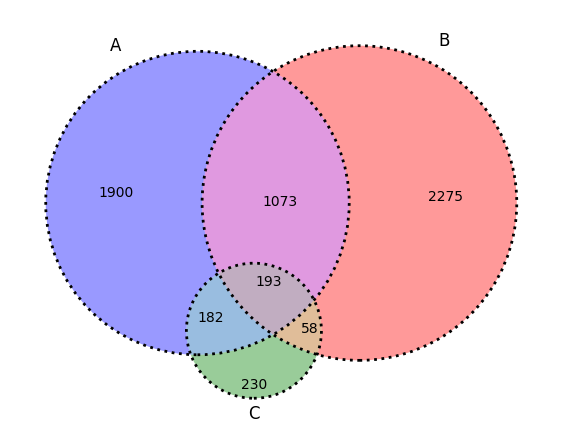

In [59]:
###########################
# Final Venn diagram and group assignment for POS/NEG used in downstream analyses

import os
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

os.makedirs("data/processed/final_set_lists/", exist_ok=True)
final_set_path = curr_wd + '/data/processed/final_set_lists/'

def create_txt_files(true_subset_LLPS, true_subset_NA, GAR_subset, path_name):
    LLPS_positive_set, NA_positive_set, GAR_subset = map(set, [true_subset_LLPS, true_subset_NA, GAR_subset])
    set_collection = []
    set_names_collection = []

    set_collection.append(LLPS_positive_set - NA_positive_set - GAR_subset)
    set_names_collection.append("1_LLPS_positive_set_only")

    set_collection.append(LLPS_positive_set & NA_positive_set - GAR_subset)
    set_names_collection.append("2_LLPS_positive_set_and_NA_positive_set")

    set_collection.append(NA_positive_set - LLPS_positive_set - GAR_subset)
    set_names_collection.append("3_NA_positive_set_only")

    set_collection.append(LLPS_positive_set & GAR_subset - NA_positive_set)
    set_names_collection.append("4_LLPS_positive_set_and_GAR_subset")

    set_collection.append(LLPS_positive_set & NA_positive_set & GAR_subset)
    set_names_collection.append("5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset")

    set_collection.append(NA_positive_set & GAR_subset - LLPS_positive_set)
    set_names_collection.append("6_NA_positive_set_and_GAR_subset")

    set_collection.append(GAR_subset - LLPS_positive_set - NA_positive_set)
    set_names_collection.append("7_GAR_subset_only")

    set_collection.extend([true_subset_LLPS, true_subset_NA, GAR_subset])
    set_names_collection.extend(["LLPS_positive_set_full", "NA_positive_set_full", "GAR_subset_full"])

    for i, sets in enumerate(set_collection):
        with open(path_name + str(set_names_collection[i]) + ".txt", 'w') as fp:
            for item in sets:
                fp.write(f"{item}\n")

# Load and prepare data
motif_info_set_df = pd.read_parquet(curr_wd + '/data/processed/' + dataset_base_name + "_cleaned_annot.parquet")

llps_pred_df = pd.read_csv(annot_path + "phasepred_human.csv")

llps_pred_df["PhaSePred"] = llps_pred_df["PhaSePred"].apply(literal_eval)
llps_pred_df["SaPS-8fea"] = [a["SaPS-8fea"] for a in llps_pred_df["PhaSePred"]]
llps_pred_df["PdPS-8fea"] = [a["PdPS-8fea"] for a in llps_pred_df["PhaSePred"]]

annotated_GO_df = pd.read_parquet(annot_path + "all_GO_human.parquet")

true_subset_LLPS = llps_pred_df[llps_pred_df["SaPS-8fea"] > 0.5]["UniqueID"].tolist()
true_subset_RNA = annotated_GO_df[annotated_GO_df["invs_RNAbind"] > 0]["UniqueID"].tolist()
true_subset_DNA = annotated_GO_df[annotated_GO_df["invs_DNAbind"] > 0]["UniqueID"].tolist()
true_subset_NA = annotated_GO_df[annotated_GO_df["invs_NAbind"] > 0]["UniqueID"].tolist()
true_subset = [value for value in true_subset_LLPS if value in true_subset_RNA]

# === Version 2 Filtering: IDR-only, not part of any domain ===
filtered_df = motif_info_set_df[motif_info_set_df['part_of_domains'].apply(lambda x: all(v == False for v in x))]

filtered_df = filtered_df[filtered_df["IDR_overlap"] == "yes"]
# === Version 3: Remove Collagen-associated proteins ===
collagen_file = curr_wd + '/data/external/UniProt/collagen_prots_human.txt'
coll_list_prot = pd.read_csv(collagen_file, sep='\t').Entry.tolist()

print("Removal of Collagen associated proteins")
print("Before:", len(filtered_df["UniqueID"].tolist()))
filtered_df = filtered_df[~filtered_df["UniqueID"].isin(coll_list_prot)]
print("After:", len(filtered_df["UniqueID"].tolist()))

# Save V3 data
temp_filtered_df = filtered_df.reset_index(drop=False)
temp_filtered_df.rename(columns={"index": "orig_motif_index"}, inplace=True)
temp_filtered_df.to_parquet(curr_wd + '/data/processed/' + dataset_base_name + "_cleaned_annot_filtered.parquet")

# Generate and save Venn diagram
GAR_subset = filtered_df["UniqueID"].tolist()
create_txt_files(true_subset_LLPS, true_subset_NA, GAR_subset, final_set_path)

plt.figure(figsize=(7, 7))
venn3([set(true_subset_LLPS), set(true_subset_NA), set(GAR_subset)],
      ("A", 'B', 'C'), set_colors=['blue', 'red', 'green'])
venn3_circles([set(true_subset_LLPS), set(true_subset_NA), set(GAR_subset)], linestyle='dotted')
plt.gcf().savefig(final_set_path + 'GARvsLLPSvsNA_Venn.png', bbox_inches='tight')
